# Generalized Logistic Growth


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import functools
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as scp
import seaborn as sns
import sklearn

import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 3.5})
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

<Figure size 432x288 with 0 Axes>

## Read the data

In [2]:
glucose_series = [
    glucose_ts.data.read_glucose_ts(os.path.join(DATA_DIR, file))
    for file in os.listdir(DATA_DIR)
]
glucose_series_0_5g = [series for series in glucose_series if series.real_concentration == 0.5]
glucose_series_1_0g = [series for series in glucose_series if series.real_concentration == 1.]

len(glucose_series_0_5g), len(glucose_series_1_0g)

(8, 8)

### One Model per time-series

We will first train the pure models on the whole time_series  . Moreover we will use the $1$ g data, as it looks more pleasing. We should do a systematic experiment data review soon.

In [3]:
generalized_lg_models_1g = [
    glucose_ts.models.GeneralizedLogisticGrowth().fit(gts.points_in_time, gts.voltages)
    for gts in glucose_series_1_0g
]


Here you can see how the concrete model parameter values. The names of the individual parameters are choosesn according to the [Wikipedia article](https://en.wikipedia.org/wiki/Generalised_logistic_function#:~:text=The%20generalized%20logistic%20function%20or%20curve,%20also%20known,Y%20(t)=A+%20{K-A%20over%20(C+Qe^%20{-Bt})^%20{1/nu%20}}}). 
In particular we chose to fix the parameters $ C=1 $ and $ Q = 1$. This is the reason why they do not appear here.

In [4]:
generalized_lg_models_1g[1].parameter

GLParameter(A=1.0190756533665535, K=0.9665642734922069, B=1.0847728827960956, nu=7.536135902900016e-05, M=-7.0225421285267124)

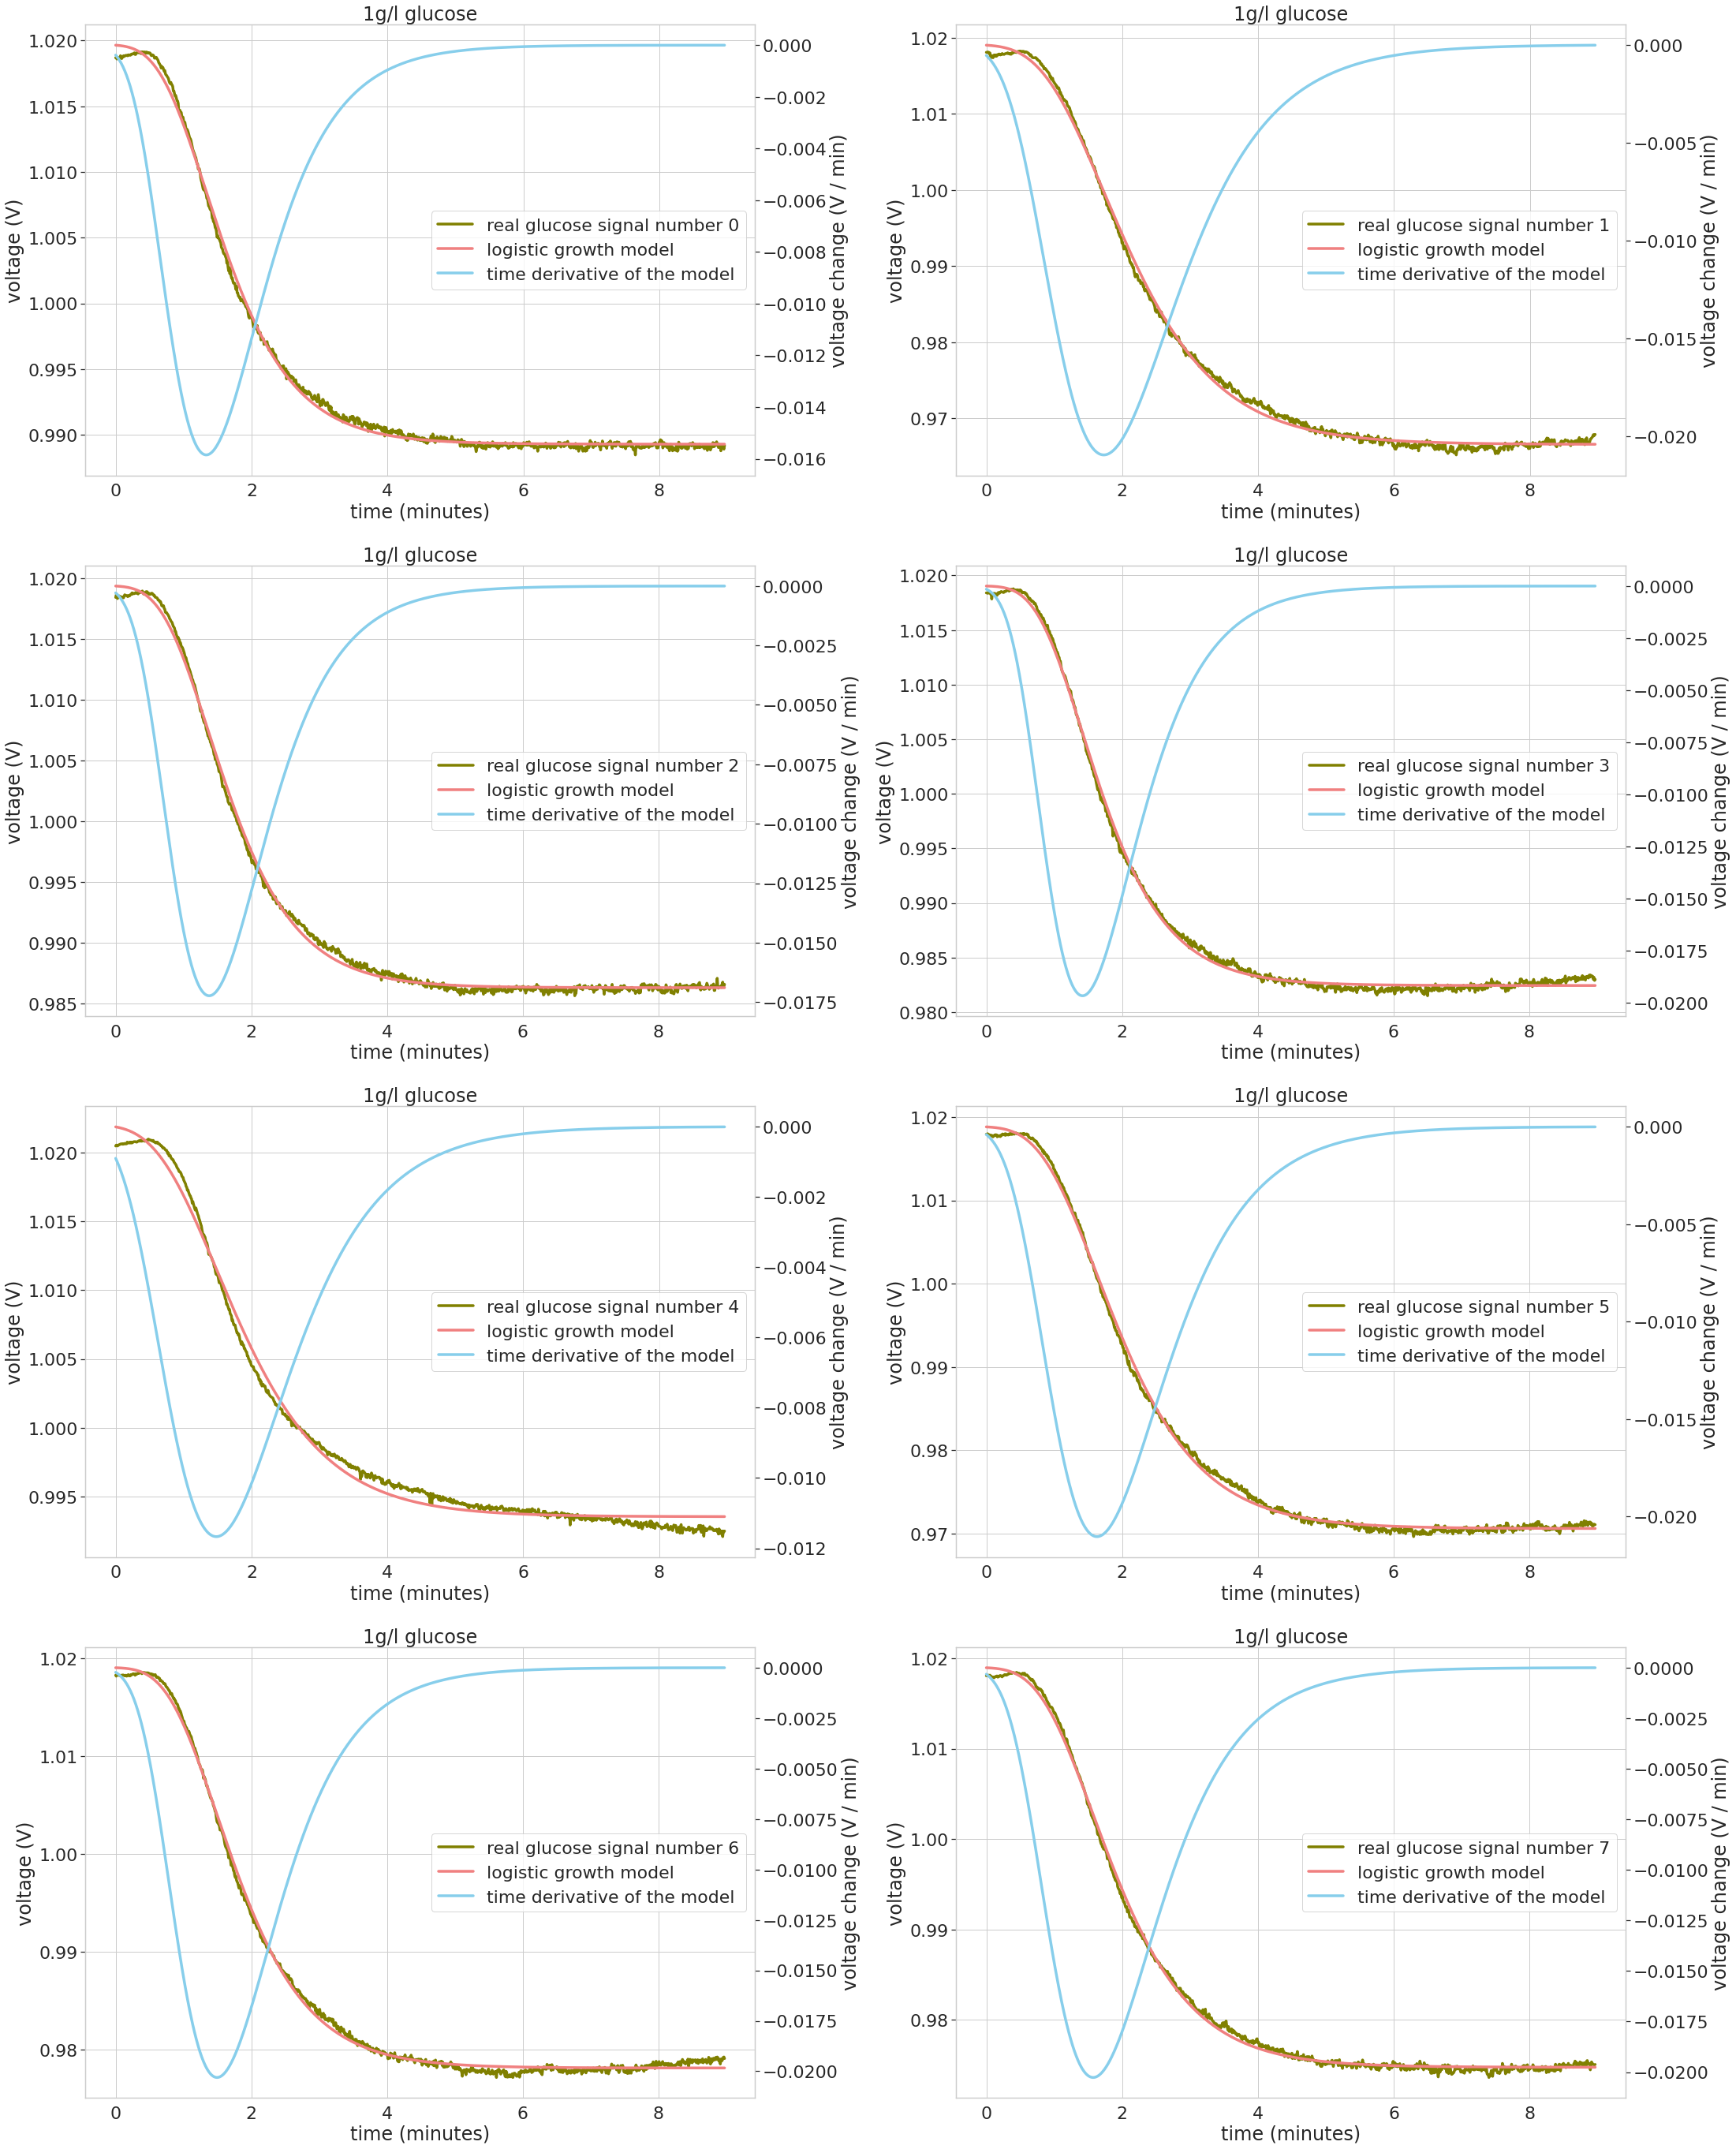

In [5]:

def plot_glucose_vs_model(glucose_timeseries, models, training_cutoff=None, title='', derivative=False):
    figure, axises = plt.subplots(int(len(models) / 2), 2, figsize=(35, int(50 * len(models) / 8)))

    for counter, ax in enumerate(axises.flatten()):

        model = models[counter]
        glucose_ts = glucose_timeseries[counter]
        legends = ax.plot(
            glucose_ts.points_in_time,
            glucose_ts.voltages,
            label='real glucose signal number %s' % (counter),
            color='olive'
        )

        # vstack in numpy
        legends += ax.plot(
            glucose_ts.points_in_time,
            model.predict(glucose_ts.points_in_time),
            label='logistic growth model',
            color='lightcoral'
        )
        
        if training_cutoff:
            ax.axvline(
                x=training_cutoff,
                label='training cutoff',
                linestyle='--',
                color='crimson'
            )
        
        handles_labels = ax.get_legend_handles_labels()

        if derivative:
            d_ax = ax.twinx()
            legends += d_ax.plot(
                glucose_ts.points_in_time,
                model.time_derivative(glucose_ts.points_in_time),
                label='time derivative of the model',
                color='skyblue'
            )
            d_ax.set_ylabel('voltage change (V / min)')
            d_ax.grid(False)
            
            handel, label = d_ax.get_legend_handles_labels()
            handles_labels[0].append(handel[0])
            handles_labels[1].append(label[0])

        ax.set_xlabel('time (minutes)')
        ax.set_ylabel('voltage (V)')
        ax.set_title(title)
        
        ax.legend(*handles_labels, loc=7)
        
    plt.subplots_adjust(bottom=0.15, wspace=0.3)
        
        
plot_glucose_vs_model(glucose_series_1_0g, generalized_lg_models_1g, title='1g/l glucose', derivative=True)

The fit for these models is quite ok, so let us check how it works, when we cut of the glucose timeseries earlier and try to fit the negative logistics growth model to it. 

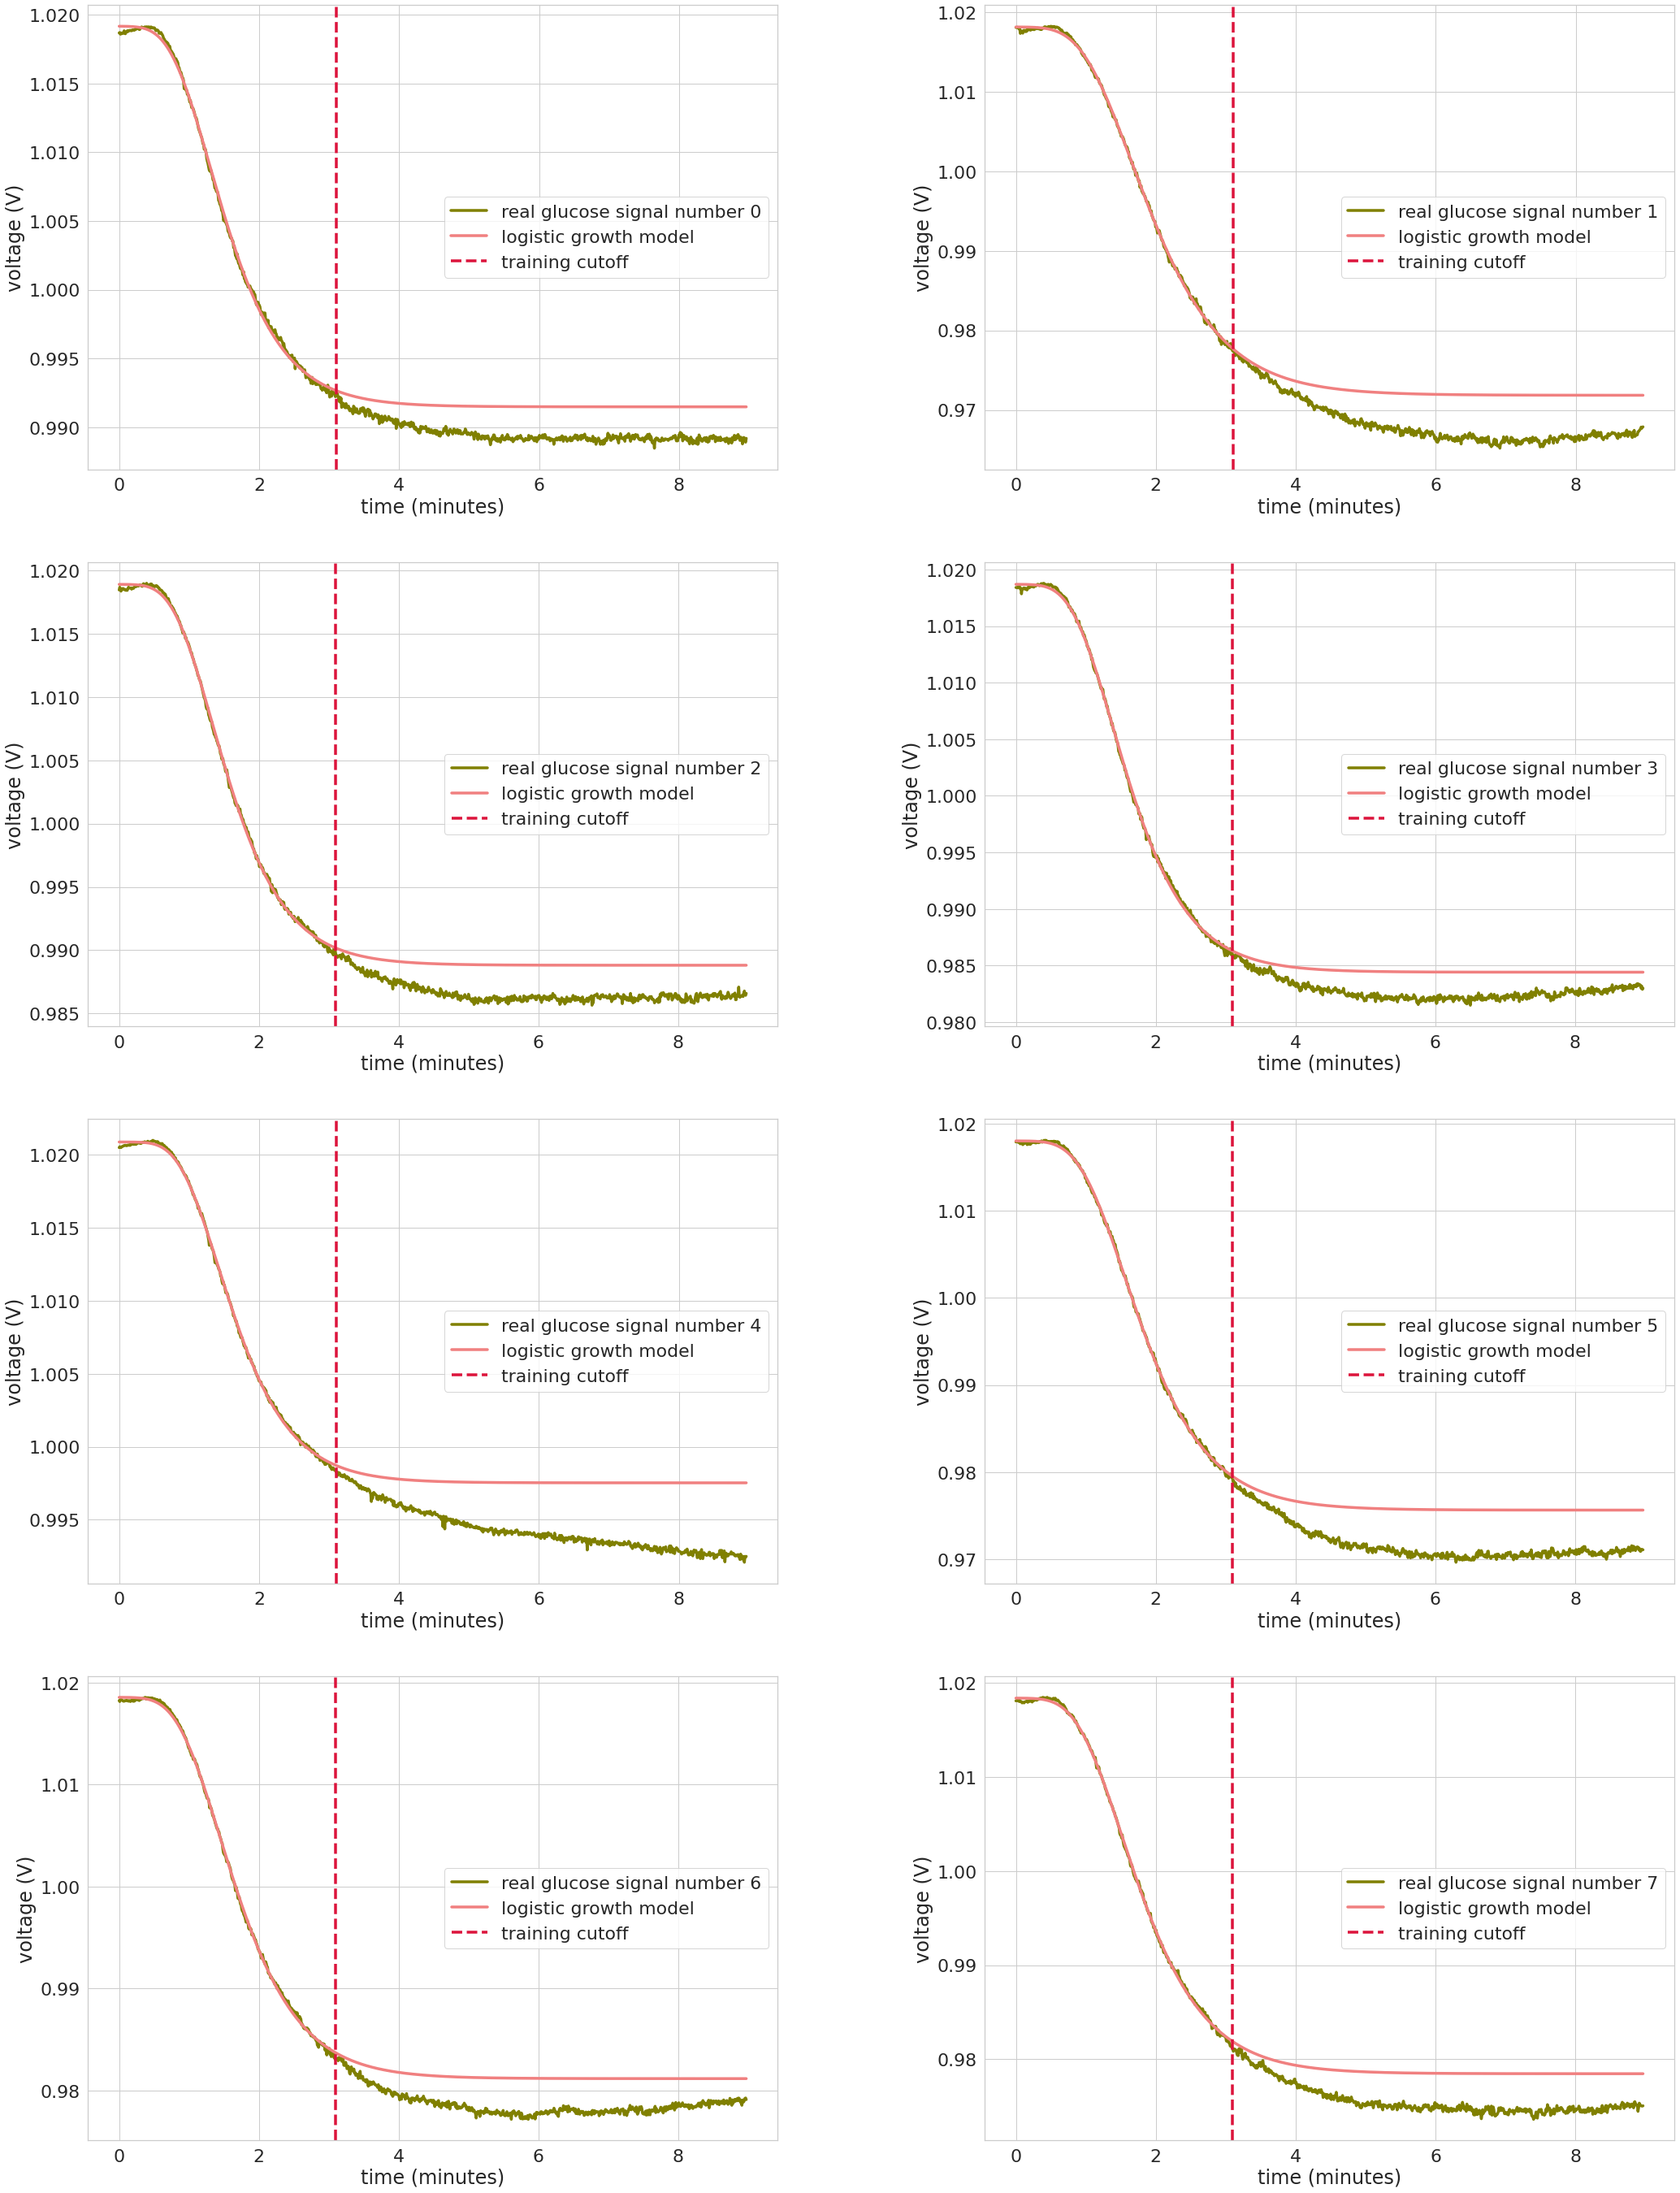

In [6]:
cut_off_time = 3.1
cutted_series = [glucose_ts.data.cut_time_series(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = [
    glucose_ts.models.GeneralizedLogisticGrowth().fit(gts.points_in_time, gts.voltages)
    for gts in cutted_series
]

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)


The last model looks quite promising. But for earlier cutoffs the algorithm does not even converge to an optimal set of parameters. Therefore we will try to use a prior distribution.

In [7]:
initial_std, std_decay = np.mean([model.std_model for model in generalized_lg_models_1g], axis=0)

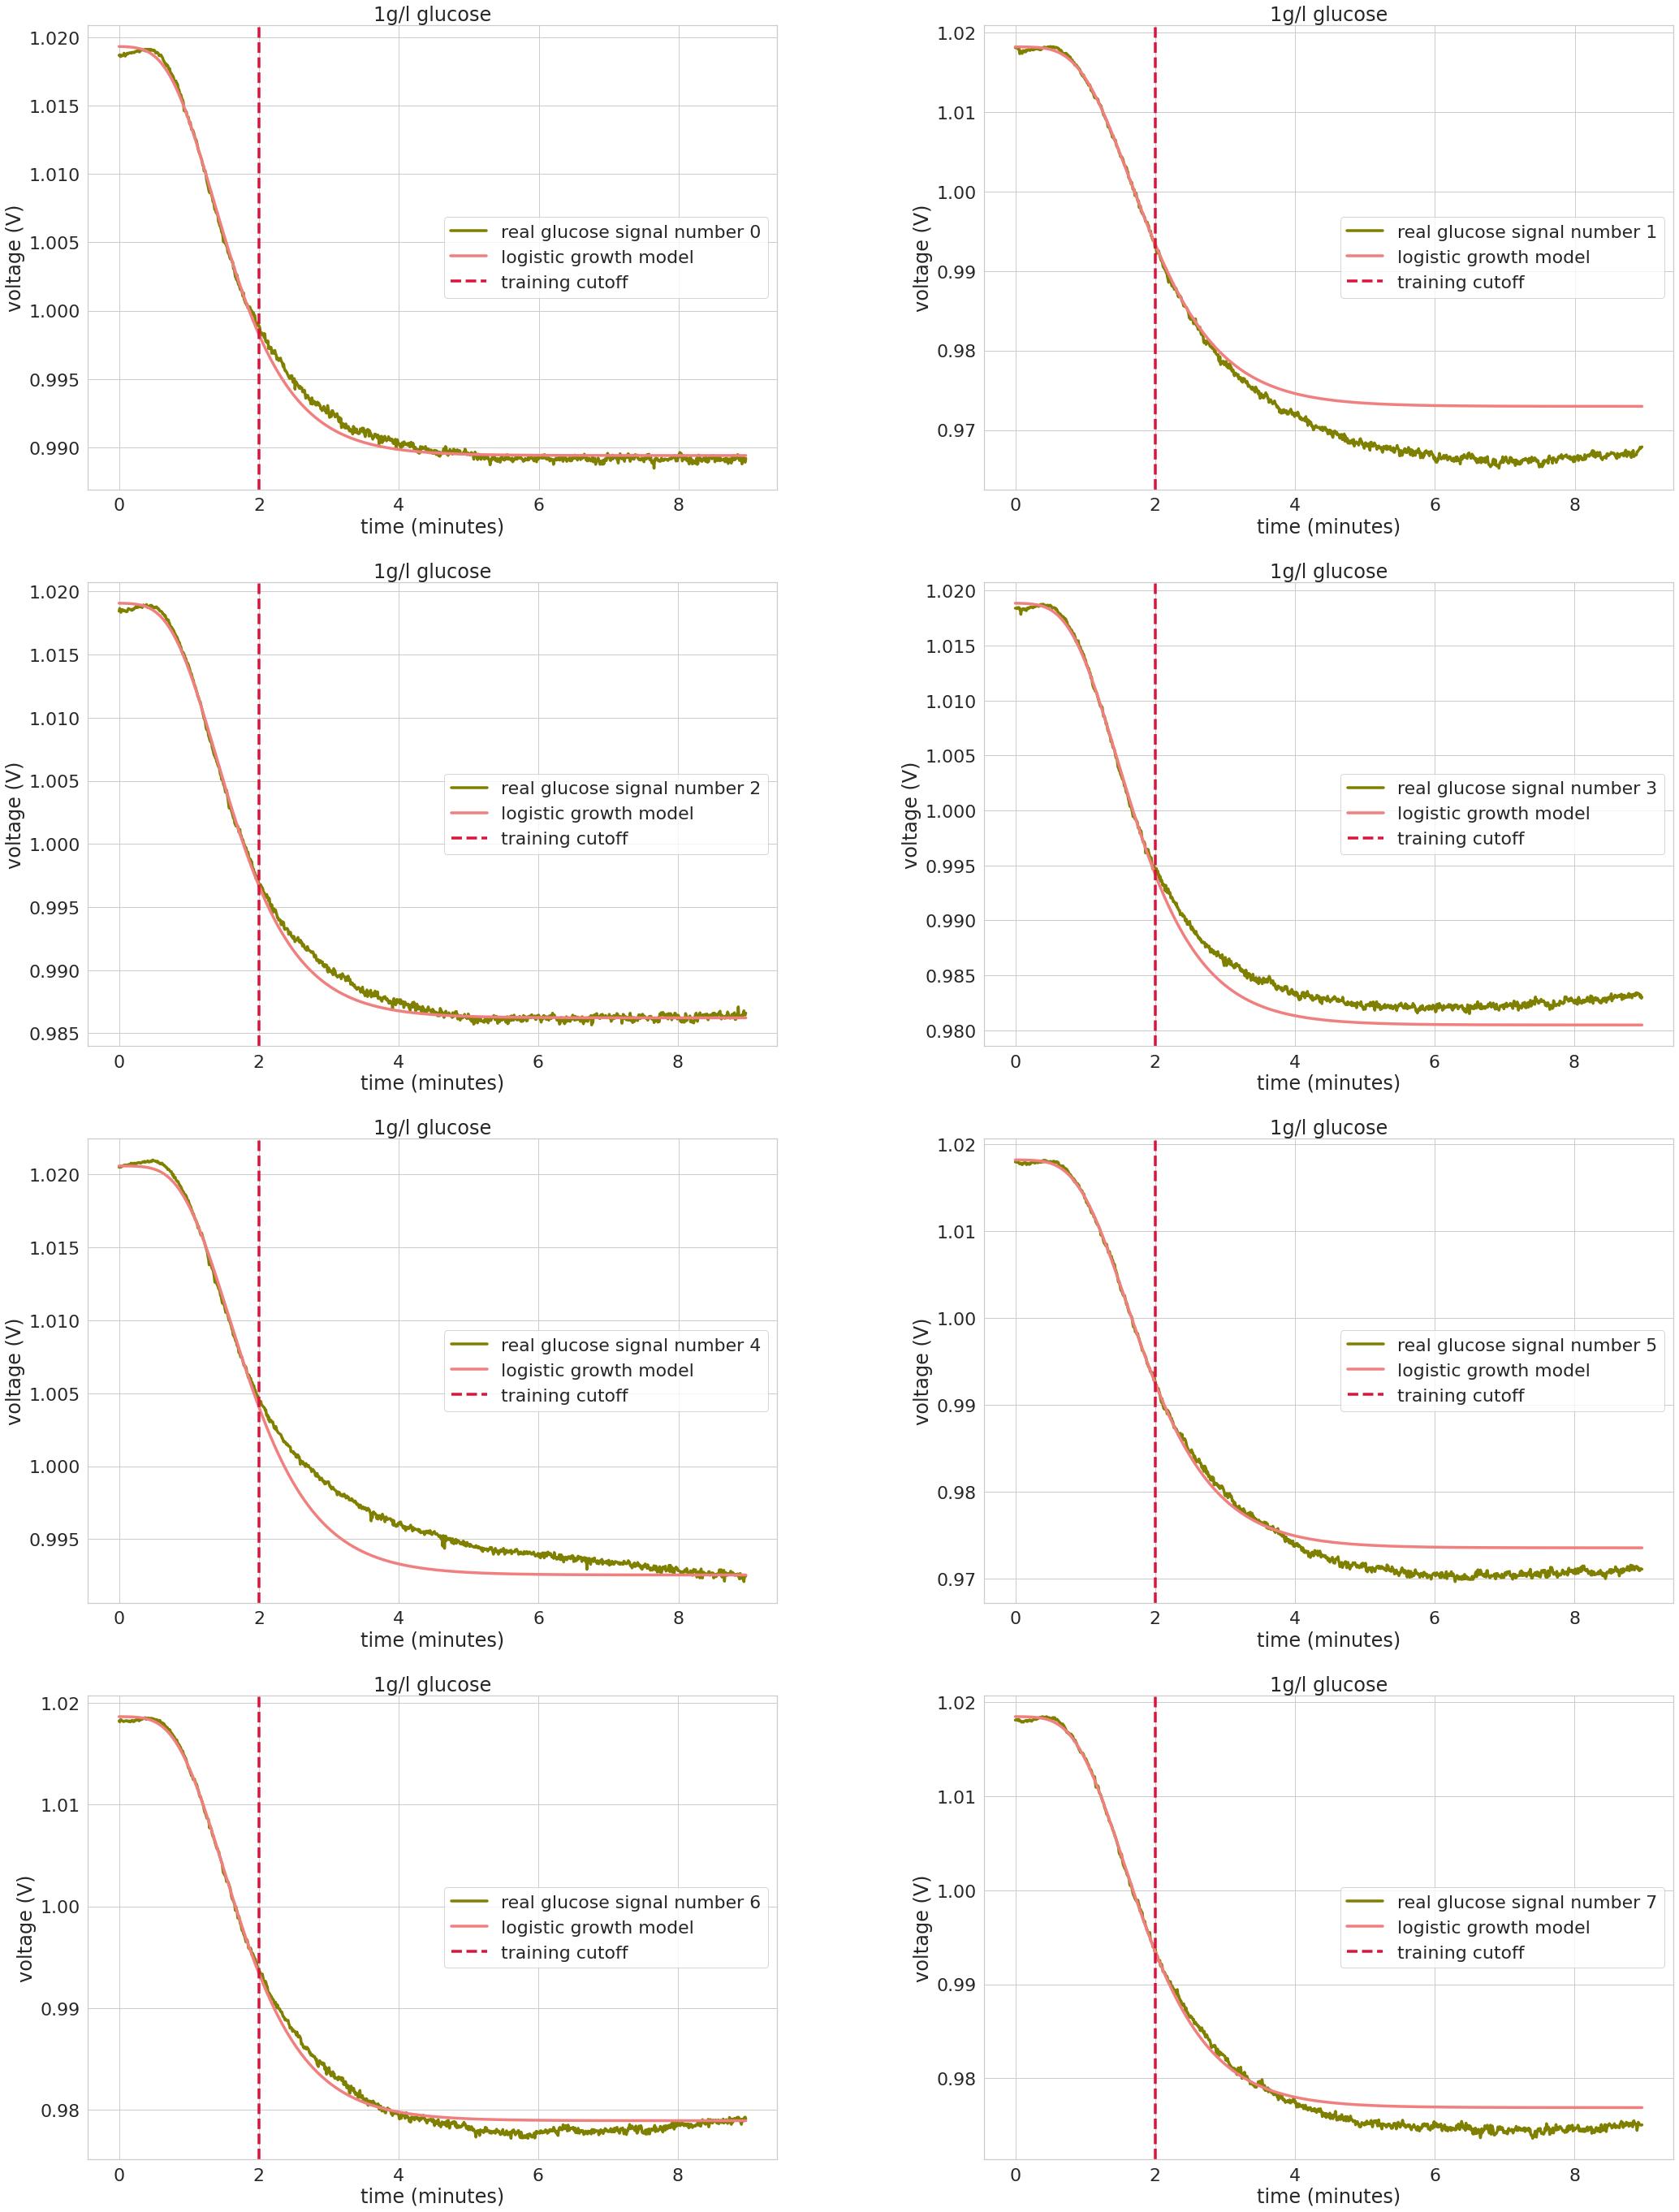

In [8]:
cut_off_time = 2
num_models = 8


gaussian_priors = [
    glucose_ts.models.get_gaussian_priors([model for count, model in enumerate(generalized_lg_models_1g) if count != idx])
    for idx in range(8)
]

cutted_series = [glucose_ts.data.cut_time_series(ts, cut_off_time) for ts in glucose_series_1_0g]


generalized_lg_with_prior = [
    glucose_ts.models.GeneralizedLogisticGrowth(
        gaussian_priors=priors,
        std_model=(initial_std, std_decay),
        time_horizon=np.max(glucose_series_1_0g[0].points_in_time)
    ).fit(
        gts.points_in_time, gts.voltages
    )
    for priors, gts in zip(gaussian_priors[:num_models], cutted_series[:num_models])
]

plot_glucose_vs_model(glucose_series_1_0g, generalized_lg_with_prior, cut_off_time, title='1g/l glucose')


Here we see that the fit for the first time horizon before the training cutoff is pretty good and after the cutoff the fit does not work that well. This is no surprise, since the model did not see the points after the cutoff. However we will try to improve the fit. Therefore I have the following ideas:
 * incorporate more data with more concentrations
 * check the variance with respect to time and incorporate it into the maximum likelihood fit
 * analyse which parameter change most and try to fix some of them during the posterior fitting process
 * try to treat the generalized logistic growth parameters as a multivariate gaussian
 * look into the Bishop and treat the variance to be unknown as well
 
 
But first things first, let us take a look at the variances of the pure model that gets the full time horizon:


In [12]:
gaussian_priors

[GLParameter(A=(1.0194904531156763, 0.001040330572416459), K=(0.9789059396046282, 0.00862623079695315), B=(1.2648152697003157, 0.13622112735750527), nu=(7.516124952125706e-05, 1.496831084636285e-06), M=(-6.067302892858508, 0.7386719053841179)),
 GLParameter(A=(1.0195775538283771, 0.001027398752806711), K=(0.9821520181764993, 0.007583533379199239), B=(1.3123239954990165, 0.12243978486380236), nu=(7.505776705538322e-05, 1.504439885731993e-06), M=(-5.83150680252156, 0.6547912697179991)),
 GLParameter(A=(1.0195305895262885, 0.0010416553372965607), K=(0.9793296082841556, 0.00904278758474301), B=(1.264987785004313, 0.13641327304893025), nu=(7.534454239855759e-05, 1.3339954928698357e-06), M=(-6.071178740846936, 0.7349326453009611)),
 GLParameter(A=(1.0195816551519563, 0.0010253276149753145), K=(0.9798842583699967, 0.009330949787221312), B=(1.258786010715152, 0.1281648564101586), nu=(7.468800343485021e-05, 9.721233227142653e-07), M=(-6.111437179679939, 0.684600185864569)),
 GLParameter(A=(1.01

In [9]:
differences = [
    glucose_ts.data.GlucoseTS(
        voltages=np.abs(series.voltages - model.predict(series.points_in_time)),
        points_in_time=series.points_in_time,
        real_concentration=1.
    )
    for series, model in zip(glucose_series_1_0g, generalized_lg_models_1g)
]

      fun: 111.1611424440009
 hess_inv: array([[ 1.12951109e-10, -2.84613042e-10],
       [-2.84613042e-10,  1.93102633e-09]])
      jac: array([975.25911427, 871.2490921 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 145
      nit: 6
     njev: 45
   status: 2
  success: False
        x: array([-5.07298694e-05,  5.85896796e-04])


<AxesSubplot:>

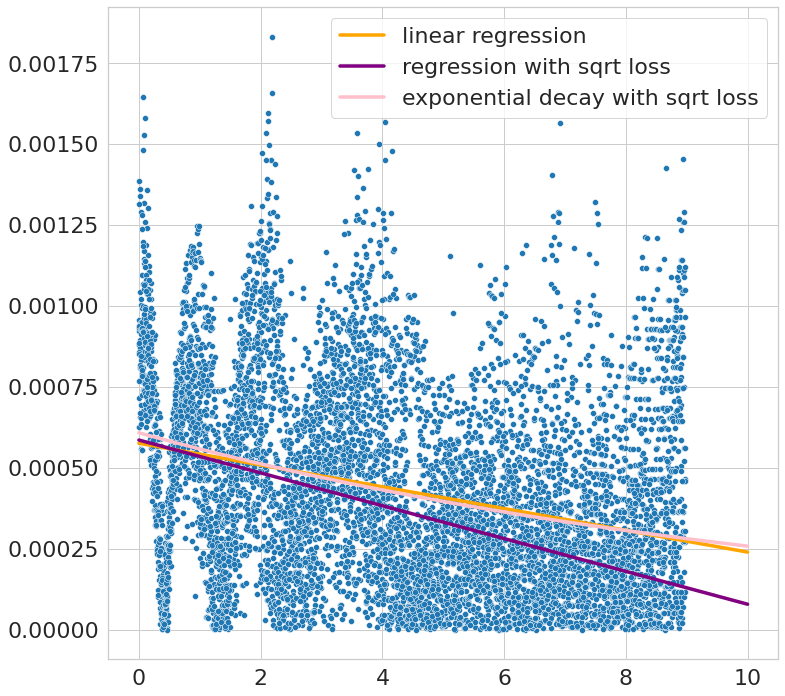

In [10]:
from sklearn import linear_model

time, diffs = functools.reduce(lambda a, b: (np.concatenate([a[0], b[0]]), np.concatenate([a[1], b[1]])), differences)

# linear regression
lr_model = linear_model.LinearRegression().fit(time.reshape(-1, 1), diffs)

# mean absolute error regression

def mean_absolute_error(slope_intercept):
    m, b = slope_intercept
    return np.sum(np.power(np.abs(diffs - (time * m + b)), 1/2))
    

result = scp.optimize.minimize(mean_absolute_error, x0=(-1e-4, 1e-3))
print(result)
slope, intercept = result.x

# exponential decay function

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

a, b = scp.optimize.curve_fit(exp_decay, time, diffs)[0]



fig, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(x=time, y=diffs, ax=ax)
sns.lineplot(
    x=np.linspace(0, 10, 101),
    y=lr_model.predict(np.linspace(0, 10, 101).reshape(-1, 1)),
    color='orange',
    label='linear regression'
)
sns.lineplot(
    x=np.linspace(0, 10, 101),
    y=slope * np.linspace(0, 10, 101) + intercept,
    color='purple',
    label='regression with sqrt loss'
)

sns.lineplot(
    x=np.linspace(0, 10, 101),
    y=exp_decay(np.linspace(0, 10, 101), a, b),
    color='pink',
    label='exponential decay with sqrt loss'
)

Text(0.5, 1.0, 'derivative vs. final value')

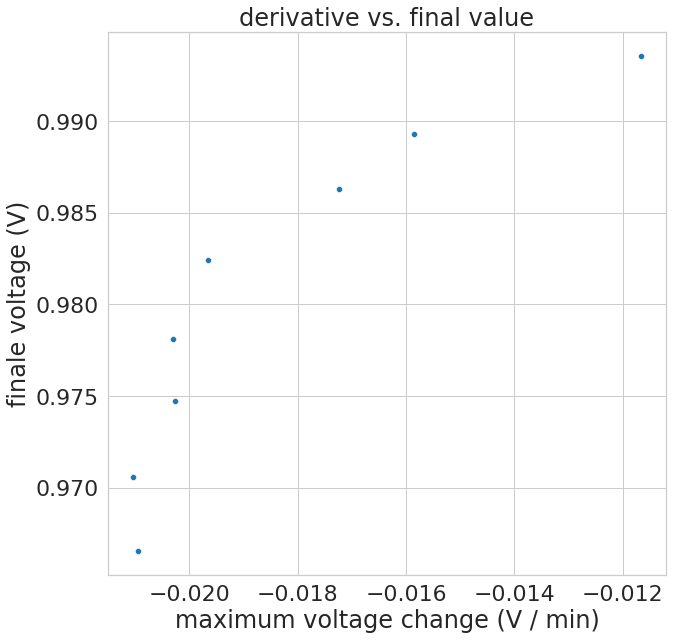

In [11]:
min_derivative, final_values = zip(*[
    (np.min(model.time_derivative(series.points_in_time)), model.parameter.K)
    for series, model in zip(glucose_series_1_0g, generalized_lg_models_1g)
])


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# ax = axises[0]

ax = sns.scatterplot(x=min_derivative, y=final_values, ax=ax)
ax.set_xlabel('maximum voltage change (V / min)')
ax.set_ylabel('finale voltage (V)')
ax.set_title('derivative vs. final value')
